# Processing of the "Construction of residentials" dataset

## Importing libraries and dataset

In [1]:
import pandas as pd
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
# pip install "folium>=0.12" matplotlib mapclassify
# pip install xlrd

# pip install keplergl
#pip install h3


In [2]:
df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_resid_geocoded_cleaned.csv",sep=",",on_bad_lines="warn")


/tmp/ipykernel_461537/433425278.py:1: DtypeWarning: Columns (4,6,24,32,34,36,38,110,116,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_resid_geocoded_cleaned.csv",sep=",",on_bad_lines="warn")


In [3]:
df.head()
df = df.iloc[1:]
df.head()



Unnamed: 0.1  Unnamed: 0  \
1             1           2   
2             2           3   
3             3           4   
4             4           5   
5             5           6   

   Code de la région du lieu des travaux - Code de la zone  \
1                                                 82         
2                                                 82         
3                                                 82         
4                                                 82         
5                                                 82         

  Code de la région du lieu des travaux - Libellé de la zone  \
1                                        Rhône-Alpes           
2                                        Rhône-Alpes           
3                                        Rhône-Alpes           
4                                        Rhône-Alpes           
5                                        Rhône-Alpes           

  Code du département du lieu des travaux - Code de la zone  \
1                                                  1          
2                                                  1          
3                                                  1          
4                                                  1          
5                                                  1          

  Code du département du lieu des travaux - Libellé de la zone  \
1                                                Ain             
2                                                Ain             
3                                                Ain             
4                                                Ain             
5                                                Ain             

  Code de la commune du lieu des travaux  \
1                                   1001   
2                                   1001   
3                                   1001   
4                                   1001   
5                                   1001   

  Type de DAU -- demande d’autorisation d’urbanisme (PC ou DP généralement, rarement PA)  \
1                                                 PC                                       
2                                                 PC                                       
3                                                 PC                                       
4                                                 PC                                       
5                                                 PC                                       

  Numéro d’enregistrement de la DAU  Etat d’avancement du projet  ...  \
1                     00100113V0004                            6  ...   
2                     00100113V0006                            6  ...   
3                     00100113V0007                            6  ...   
4                     00100113V0008                            6  ...   
5                     00100114V0001                            5  ...   

                  result_name               result_street result_postcode  \
1  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
2  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
3  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
4  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
5           Chemin de l'Ordre           Chemin de l'Ordre          1400.0   

               result_city                 result_context result_citycode  \
1  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   
2  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   
3  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   
4  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   
5  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   

  result_oldcitycode result_oldcity  result_district result_status  
1                NaN          

## Grouping columns together
To do so, we target columns with the same name

In [4]:
for c in df.columns:
    print(c)

Unnamed: 0.1
Unnamed: 0
Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Type de DAU -- demande d’autorisation d’urbanisme (PC ou DP généralement, rarement PA)
Numéro d’enregistrement de la DAU
Etat d’avancement du projet
Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale
Date réelle d’ouverture de chantier
Date réelle d’achèvement des travaux
Année de dépôt de la DAU
Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)
Date (mois) de prise en compte (DPC) de l’autorisation initiale
Date (mois) de prise en compte (DPC) de l’ouverture du chantier
Date (mois) (DPC) de dernière mise à jour des données
Catégorie du demandeur (maître d’ouvrage) selon Sitadel
Code d’activité principale de l’établ

In [5]:
col_metadata = [x for x in df.columns if "DAU" in x] + ["Unnamed: 0"]
col_meta_location = [x for x in df.columns if "lieu des travaux" in x]
col_dates_travaux = [x for x in df.columns if "Date" in x]
col_demandeurs = [x for x in df.columns if "demandeur" in x ]
col_precise_location = [x for x in df.columns if "du terrain" in x and ("Superficie du terrain" not in x)] 
col_cadastres = [x for x in df.columns if "cadastr" in x]
col_construction_details = [x for x in df.columns if "Présence" in x or "Indicateur" in x] #dans le projet 
col_number_created_housings_details = [x for x in df.columns if "logements" in x and "créés" in x and "Nombre total de logements créés" not in x]
col_details_transf = [x for x in df.columns if "Surface" in x]
col_from_geocodage = [i for i in df.columns if "result_" in i]

col_irrelevant = col_metadata + col_dates_travaux + col_precise_location + col_cadastres + col_construction_details + col_number_created_housings_details + col_details_transf + col_from_geocodage
col_relevant =  [c for c in df.columns if c not in col_irrelevant] 
for c in col_relevant:
    print(c)

Unnamed: 0.1
Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Etat d’avancement du projet
Catégorie du demandeur (maître d’ouvrage) selon Sitadel
Code d’activité principale de l’établissement d’un demandeur avéré en tant que personne morale
Catégorie juridique d’un demandeur avéré en tant que personne morale
Dénomination d’un demandeur avéré en tant que personne morale
Numéro SIREN d’un demandeur avéré en tant que personne morale
Numéro SIRET d’un demandeur avéré en tant que personne morale
Code postal du demandeur
Localité du demandeur
Superficie du terrain
Code zone opératoire
Nature du projet déclarée par le demandeur
Nature de projet détaillée
Destination principale
Type principal de transformation
Type principal des locaux d’origine transformés
Nombre de niveau

In [6]:
df.loc[:,col_relevant].sample()



Unnamed: 0.1  \
1061387       1061387   

         Code de la région du lieu des travaux - Code de la zone  \
1061387                                                 31         

        Code de la région du lieu des travaux - Libellé de la zone  \
1061387                                 Nord-Pas-de-Calais           

        Code du département du lieu des travaux - Code de la zone  \
1061387                                                 59          

        Code du département du lieu des travaux - Libellé de la zone  \
1061387                                               Nord             

        Code de la commune du lieu des travaux  Etat d’avancement du projet  \
1061387                                  59129                            2   

         Catégorie du demandeur (maître d’ouvrage) selon Sitadel  \
1061387                                                 10         

        Code d’activité principale de l’établissement d’un demandeur avéré en tant que personne morale  \
1061387                                                NaN                                               

         Catégorie juridique d’un demandeur avéré en tant que personne morale  \
1061387                                                NaN                      

         ... Type d’annexe  Type de résidence  \
1061387  ...             7                  9   

         Nombre total de logements créés Nombre de logements démolis  \
1061387                                1                           0   

        Nb de logements locatifs sociaux  Nb de logements aidé (hors ptz)  \
1061387                                0                                0   

         Nb de logements ptz                         Adresse_complete  \
1061387                    0  14 RUE D HUQUINVILLE CAPPELLE-EN-PEVELE   

         longitude   latitude  
1061387   3.194464  50.509631  

[1 rows x 35 columns]

In [7]:
plt.figure(figsize=(20,10))

#sns.heatmap(df.isna(), cbar=False)


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [8]:
df["Nombre total de logements créés"].sample()

783192    1
Name: Nombre total de logements créés, dtype: int64

#### **REACTIVER A LA FIN, DESACTIVER TEMPORAIREMENT**

def identification_usage(ligne):
    col_max = ligne.iloc[len(dates_lieux_travaux):].idxmax()
    pattern = r"Surface de plancher de la destination (.+?) (nouvelle construite|issue d'une transformation)$"

    match = re.search(pattern, col_max, re.IGNORECASE)
    print("Testing column:", repr(col_max))
    return match.group(1) if match else None

df_usage = df.loc[:,colonnes_pertinentes].sample(1000)
df_usage["Destination du lieu"]= df_usage.apply(identification_usage, axis = 1)



## Arranging columns types 


In [9]:
dico_variables = pd.read_excel("https://data.statistiques.developpement-durable.gouv.fr/dido/api/files/ab799b04-0b03-4f96-949c-eb23c478a8e8")

In [10]:
dico_variables.head()


Nom de la variable                         Description de la variable  \
0                REG              Code de la région du lieu des travaux   
1                DEP            Code du département du lieu des travaux   
2               COMM             Code de la commune du lieu des travaux   
3           Type_DAU  Type de DAU -- demande d'autorisation d'urbani...   
4            Num_DAU                  Numéro d'enregistrement de la DAU   

  Nouveau mai 2022?                                          Modalités  \
0               NaN  Nomenclature du Code Officiel Géographique (CO...   
1               NaN                                                NaN   
2               NaN  Nomenclature du Code Officiel Géographique (CO...   
3               NaN  PC (Permis de construire)\nDP (Déclaration Pré...   
4               NaN                                                NaN   

                          Format  \
0   Alphanumérique, 2 caractères   
1   Alphanumérique, 2 caractères   
2   Alphanumérique, 5 caractères   
3   Alphanumérique, 2 caractères   
4  Alphanumérique, 13 caractères   

                                        Observations  \
0                                                NaN   
1                                                NaN   
2  Le code vient directement du numéro d'enregist...   
3                                                NaN   
4  Numéro sur 13 caractères : les 6 premiers cara...   

                             Origine  
0  Numéro d'enregistrement de la DAU  
1  Numéro d'enregistrement de la DAU  
2  Numéro d'enregistrement de la DAU  
3  Numéro d'enregistrement de la DAU  
4  Numéro d'enregistrement de la DAU

### Retrouver depuis le dictionnaire 

In [11]:
def variable_types(ligne):
    if ("Année" in ligne["Description de la variable"]):
        return None
    if "Alphanumérique" in ligne["Format"]:
        return "string"
    if "Numérique" in ligne["Format"]:
        return "float64"
        
dico_variables["Format_python"] = dico_variables.apply(variable_types, axis=1)


In [12]:
dtype_map = dict(zip(dico_variables["Description de la variable"], dico_variables["Format_python"]))
dtype_map = {col : python_type for col, python_type in dtype_map.items() if col in df.columns}
df = df.astype(dtype_map, errors="ignore")


In [13]:
df.dtypes.to_frame().style

### Régler la question de la date 

In [14]:
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].value_counts().to_frame().style #to verify that dates are well specified under the format %Y%m, i.e. year with 4 digits followed by month
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"] = pd.to_datetime(df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"], format="%Y-%m", errors="coerce")


We repeat the operation for the other columns that involve date/year dtypes


In [15]:
for col_date in col_dates_travaux:
    print(df[col_date].value_counts().to_frame()) #to verify the format of the date

                                                    count
Date réelle d’autorisation (PC) ou de non-oppos...       
2013-02-21                                           1603
2013-02-28                                           1340
2022-02-10                                           1260
2013-02-20                                           1215
2013-02-14                                           1208
...                                                   ...
2025-11-01                                              2
2020-05-01                                              2
2025-11-10                                              2
2025-09-14                                              2
2025-11-13                                              1

[4695 rows x 1 columns]
                                     count
Date réelle d’ouverture de chantier       
2014-09-01                            1447
2021-09-01                            1432
2021-03-01                            1349
2018-1

In [16]:
col_date_format_ymd = [col_dates_travaux[i] for i in [0,1,2,3]]
col_date_format_ym = [col_dates_travaux[i] for i in [4,5,6]]

In [17]:
for col in col_date_format_ymd:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")



1          2013-09-30
2          2013-09-20
3          2013-11-16
4          2013-12-06
5          2014-04-09
              ...    
1834049    2025-04-21
1834050    2013-08-15
1834051    2013-08-15
1834052    2016-11-09
1834053    2024-10-16
Name: Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale, Length: 1834053, dtype: object
1          2013-12-06
2          2013-11-26
3          2014-01-24
4          2014-03-12
5          2014-06-16
              ...    
1834049           NaN
1834050    2015-02-05
1834051    2015-02-05
1834052           NaN
1834053           NaN
Name: Date réelle d’ouverture de chantier, Length: 1834053, dtype: object
1          2014-08-08
2          2014-06-27
3          2014-04-09
4          2014-11-14
5                 NaN
              ...    
1834049           NaN
1834050           NaN
1834051           NaN
1834052           NaN
1834053           NaN
Name: Date réelle d’achèvement des travaux, Length: 1834053, dtype: object
1         2013-08-01

In [18]:
for col in col_date_format_ym:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m")


1          2013-10
2          2013-11
3          2013-11
4          2013-12
5          2014-04
            ...   
1834049    2025-04
1834050    2014-02
1834051    2014-02
1834052    2017-01
1834053    2024-10
Name: Date (mois) de prise en compte (DPC) de l’autorisation initiale, Length: 1834053, dtype: object
1          2014-01
2          2013-12
3          2014-02
4          2014-03
5          2014-07
            ...   
1834049        NaN
1834050    2015-02
1834051    2015-02
1834052        NaN
1834053        NaN
Name: Date (mois) de prise en compte (DPC) de l’ouverture du chantier, Length: 1834053, dtype: object
1          2014-08
2          2014-07
3          2014-04
4          2015-02
5          2014-07
            ...   
1834049    2025-04
1834050    2015-02
1834051    2015-02
1834052    2017-01
1834053    2024-10
Name: Date (mois) (DPC) de dernière mise à jour des données, Length: 1834053, dtype: object


In [19]:
col = "Année de dépôt de la DAU"
print(df[col])
df[col] = df[col].astype("int64")

1          2013
2          2013
3          2013
4          2013
5          2014
           ... 
1834049    2025
1834050    2013
1834051    2013
1834052    2016
1834053    2024
Name: Année de dépôt de la DAU, Length: 1834053, dtype: int64


### Compléter les dernières colonnes

In [20]:
df = df.astype({col : "float64" for col in col_details_transf + ["Superficie du terrain"]})

df = df.astype({col : "string" for col in col_meta_location + col_cadastres + ["Code zone opératoire"]})
df = df.astype({col : "string" for col in ["Adresse_complete"]})


In [21]:
df.dtypes.to_frame().style

## Cleaning per column



### Cleaning dates 

In [22]:
df.loc[:,col_dates_travaux].sample(20)


Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  \
516796                                          2015-11-16                   
1077554                                         2016-06-23                   
1461608                                         2024-10-25                   
809988                                          2020-05-27                   
944789                                          2015-10-29                   
1314042                                         2020-11-14                   
709696                                          2017-04-24                   
690030                                          2013-01-16                   
791376                                          2020-11-28                   
665102                                          2022-02-14                   
1627346                                         2018-02-06                   
162025                                          2019-07-25                   
547386                                          2019-04-01                   
447672                                          2015-10-19                   
562373                                          2020-12-21                   
1236437                                         2015-01-05                   
1243832                                         2017-07-20                   
1044453                                         2016-07-26                   
362161                                          2021-07-21                   
1256173                                         2022-02-18                   

        Date réelle d’ouverture de chantier  \
516796                                  NaT   
1077554                          2017-02-15   
1461608                                 NaT   
809988                           2020-10-28   
944789                           2016-01-20   
1314042                          2021-02-10   
709696                                  NaT   
690030                           2013-03-06   
791376                                  NaT   
665102                           2022-07-11   
1627346                          2019-01-06   
162025                           2020-06-18   
547386                           2020-02-01   
447672                           2016-09-01   
562373                           2021-05-25   
1236437                          2015-04-16   
1243832                                 NaT   
1044453                                 NaT   
362161                           2022-05-20   
1256173                                 NaT   

        Date réelle d’achèvement des travaux  \
516796                                   NaT   
1077554                           2018-04-21   
1461608                                  NaT   
809988                            2022-01-04   
944789                                   NaT   
1314042                                  NaT   
709696                                   NaT   
690030                            2014-01-20   
791376                                   NaT   
665102                            2024-01-15   
1627346                           2020-11-24   
162025                            2021-06-21   
547386                            2021-11-25   
447672                                   NaT   
562373                                   NaT   
1236437                           2016-07-01   
1243832                                  NaT   
1044453                                  NaT   
362161                                   NaT   
1256173                                  NaT   

        Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)  \
516796                                          2015-10-01                                                                  
1077554                                         2016-02-01                                                                

On regarde si les dates mis à part la colonne des années sont cohérentes, ce qui semble être le cas 

In [23]:
df[df[col_dates_travaux].gt(pd.Timestamp.today()).any(axis=1)][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


Empty DataFrame
Columns: [Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale, Date réelle d’ouverture de chantier, Date réelle d’achèvement des travaux, Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation), Date (mois) de prise en compte (DPC) de l’autorisation initiale, Date (mois) de prise en compte (DPC) de l’ouverture du chantier, Date (mois) (DPC) de dernière mise à jour des données, Année de dépôt de la DAU]
Index: []

In [24]:
df[df["Année de dépôt de la DAU"]>2025][col_dates_travaux+["Année de dépôt de la DAU"]].head(50)


Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  \
3947                                            2013-04-03                   
131362                                          2013-11-04                   
143298                                          2013-07-18                   
157854                                          2014-06-13                   
461002                                          2015-04-08                   
479028                                          2014-07-02                   
1357016                                         2014-07-21                   
1443919                                         2013-02-14                   
1469110                                         2013-03-08                   
1512477                                         2015-01-20                   
1525814                                         2013-08-28                   
1535657                                         2014-02-13                   
1631117                                         2014-12-18                   
1682187                                         2015-03-12                   
1682188                                         2015-03-12                   
1707868                                         2013-12-12                   
1719720                                         2013-08-20                   
1731772                                         2013-08-02                   
1753559                                         2014-02-27                   

        Date réelle d’ouverture de chantier  \
3947                                    NaT   
131362                                  NaT   
143298                                  NaT   
157854                                  NaT   
461002                                  NaT   
479028                           2014-07-02   
1357016                                 NaT   
1443919                                 NaT   
1469110                                 NaT   
1512477                                 NaT   
1525814                                 NaT   
1535657                          2014-02-13   
1631117                                 NaT   
1682187                                 NaT   
1682188                                 NaT   
1707868                                 NaT   
1719720                                 NaT   
1731772                                 NaT   
1753559                                 NaT   

        Date réelle d’achèvement des travaux  \
3947                                     NaT   
131362                                   NaT   
143298                                   NaT   
157854                                   NaT   
461002                                   NaT   
479028                            2014-07-09   
1357016                                  NaT   
1443919                                  NaT   
1469110                                  NaT   
1512477                                  NaT   
1525814                                  NaT   
1535657                           2014-03-18   
1631117                                  NaT   
1682187                                  NaT   
1682188                                  NaT   
1707868                                  NaT   
1719720                                  NaT   
1731772                                  NaT   
1753559                                  NaT   

        Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)  \
3947                                            2013-04-01                                                                  
131362                                          2013-09-01                                                                  
143298                                          2013-07-01                                                                  
157854                                       

In [25]:
ligns_gt_today = df["Année de dépôt de la DAU"]>2025
df.loc[ligns_gt_today,"Année de dépôt de la DAU"] = df.loc[ligns_gt_today,"Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].dt.year

In [26]:
df[df["Année de dépôt de la DAU"]>2025][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


Empty DataFrame
Columns: [Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale, Date réelle d’ouverture de chantier, Date réelle d’achèvement des travaux, Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation), Date (mois) de prise en compte (DPC) de l’autorisation initiale, Date (mois) de prise en compte (DPC) de l’ouverture du chantier, Date (mois) (DPC) de dernière mise à jour des données, Année de dépôt de la DAU]
Index: []

On cherche à voir les années avant lesquelles il y a peu de données et qu'il vaut mieux supprimer pour l'analyse statistique 

<Axes: xlabel='Année de dépôt de la DAU'>

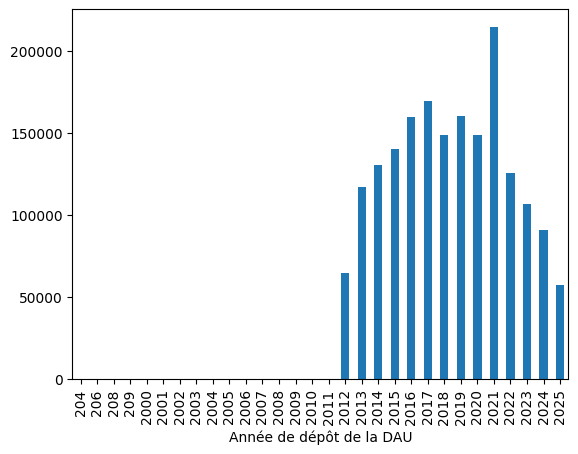

In [27]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot.bar()


On peut supprimer tout ce qui vient avant 2012, 2012 compris ainsi que l'année 2025 qui est en cours 

In [28]:
ligns_few_values = (df["Année de dépôt de la DAU"]<=2012) | (df["Année de dépôt de la DAU"] == 2025)
df = df.drop(df.index[ligns_few_values])

<Axes: xlabel='Année de dépôt de la DAU'>

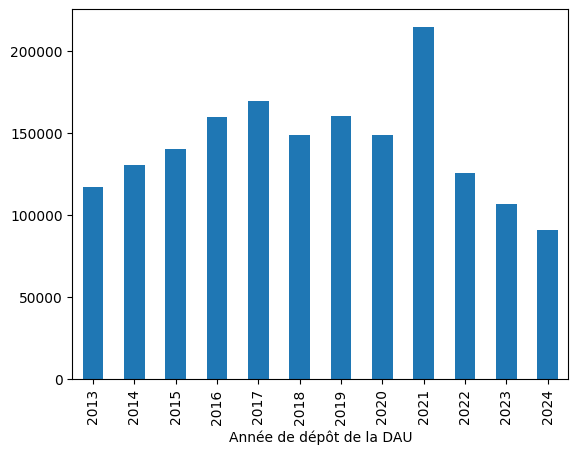

In [29]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot.bar()


### Cleaning Departments 

In [30]:
df["Code du département du lieu des travaux - Code de la zone"].nunique()

102

We see that there are 102 departments instead of 101, as for the previous notebook, we imagine that the problem is that one department is coded two times, one time with one digit (2, Aisne) and the other with two (02, Aisne). We harmonize the gap

In [31]:
df.loc[df["Code du département du lieu des travaux - Code de la zone"].str.len()==1,"Code du département du lieu des travaux - Code de la zone"] 

1          1
2          1
3          1
4          1
5          1
          ..
1808896    9
1808897    9
1808898    9
1808899    9
1808900    9
Name: Code du département du lieu des travaux - Code de la zone, Length: 92996, dtype: string

In [32]:
df["Code du département du lieu des travaux - Code de la zone"]=df["Code du département du lieu des travaux - Code de la zone"].str.zfill(2)

### Isolating overseas departments (DOM)

In [33]:
df_dom = df.loc[df["Code du département du lieu des travaux - Code de la zone"].str.startswith("97")] 
df = df.drop(df_dom.index)

<Axes: xlabel='Année de dépôt de la DAU'>

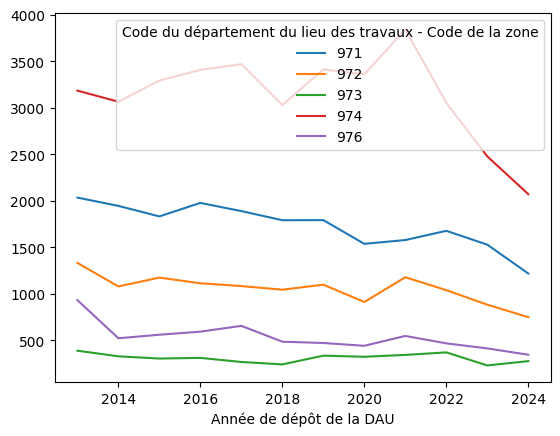

In [34]:
df_dom.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot()


###  TODO Replacing qualitative numeric value by its name 

In [35]:
destinations = [
    "habitation",
    "hébergement hôtelier",
    "bureaux",
    "commerce",
    "artisanat",
    "industrie",
    "agriculture",
    "entrepôt",
    "service public ou d'intérêt collectif"
]

dict_destination_principale = {key: value for key, value in zip(range(1, 10), destinations)}


In [36]:
df.loc[~df["Destination principale"].isin(range(1, 10)),"Destination principale"]

1          1
2          1
3          1
4          1
5          1
          ..
1833308    1
1833309    1
1833310    1
1833311    1
1833312    1
Name: Destination principale, Length: 1630058, dtype: string

In [37]:

df["Destination principale"] = pd.to_numeric(df["Destination principale"],errors="coerce")
df["Destination principale"] = df["Destination principale"].apply(lambda x : dict_destination_principale[x])


## First descriptive statistics 

### TODO : Main usage of the building before and after 

In [38]:
df["Destination principale"].value_counts()

Destination principale
habitation    1630058
Name: count, dtype: int64

### Construction Activity Time Series

<Axes: xlabel='Année de dépôt de la DAU'>

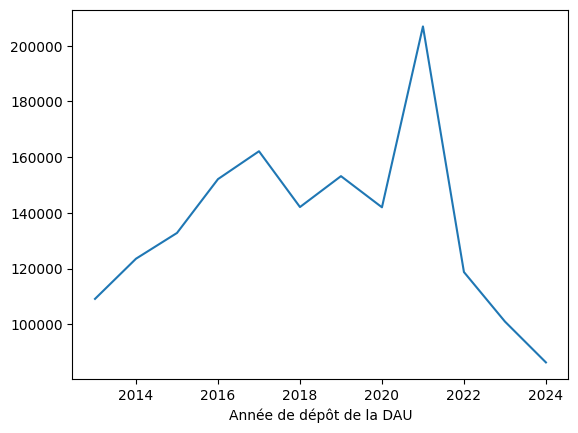

In [39]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot()


In [40]:
df["Date"] = df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"]


In [41]:
df[df["Date"].dt.year<=2012][col_dates_travaux+["Année de dépôt de la DAU"]]


Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  \
33716                                           2013-02-15                   
69384                                           2013-02-27                   
129309                                          2013-06-24                   
145209                                          2013-04-23                   
316493                                          2013-01-22                   
454725                                          2013-06-19                   
494688                                          2013-02-28                   
676562                                          2020-07-29                   
687073                                          2020-03-06                   
701265                                          2013-01-18                   
1057831                                         2013-07-11                   
1144105                                         2013-05-29                   
1533766                                         2013-05-21                   

        Date réelle d’ouverture de chantier  \
33716                                   NaT   
69384                                   NaT   
129309                           2014-12-18   
145209                           2013-05-01   
316493                                  NaT   
454725                           2014-06-05   
494688                           2013-03-07   
676562                           2020-08-01   
687073                           2020-07-01   
701265                                  NaT   
1057831                                 NaT   
1144105                          2014-01-31   
1533766                          2014-01-15   

        Date réelle d’achèvement des travaux  \
33716                                    NaT   
69384                                    NaT   
129309                            2016-08-31   
145209                            2014-10-03   
316493                                   NaT   
454725                            2016-04-08   
494688                            2016-05-10   
676562                                   NaT   
687073                            2021-01-01   
701265                                   NaT   
1057831                                  NaT   
1144105                                  NaT   
1533766                           2016-03-14   

        Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)  \
33716                                           2012-12-01                                                                  
69384                                           2012-12-01                                                                  
129309                                          2012-12-01                                                                  
145209                                          2012-12-01                                                                  
316493                                          2012-12-01                                                                  
454725                                          2012-12-01                                                                  
494688                                          2012-12-01                                                                  
676562                                          2010-03-01                                                                  
687073                                          2010-06-01                                                                  
701265                                          2012-12-01                                                                  
1057831                                         2012-12-01                                                                  
1144105                                         2012-09-01                         

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.9699e+04, 4.9304e+04, 4.3672e+04,
        5.1513e+04, 4.9225e+04, 4.2507e+04, 5.4800e+04, 5.5257e+04,
        4.8526e+04, 6.2422e+04, 7.0597e+04, 5.4236e+04, 6.8072e+04,
        5.6268e+04, 4.7725e+04, 6.2258e+04, 6.5801e+04, 5.1762e+04,
        5.2367e+04, 5.8601e+04, 5.6654e+04, 7.5062e+04, 7.5336e+04,
        6.6221e+04, 5.6605e+04, 5.1810e+04, 3.6432e+04, 4.1772e+04,
        3.7269e+04, 3.0415e+04, 3.5513e+04, 2.0090e+03, 3.4100e+02]),
 array([14669.   , 14811.325, 14953.65 , 15095.975, 15238.3  , 15380.625,
        15522.95 , 15665.275, 15807.6  , 15949.925, 16092.25 , 16234.575,
        16376.9  , 16519.225, 16661.55 , 16803.875, 16946.2  , 17088.525,
        17230.85 , 17373.175, 17515.5  , 17657.825, 17800.15 , 17942.475,
        18084.8  , 18227.125, 18369.45 , 18511.775, 18654.1  , 18796.425,
        18938.75 , 19081.075, 19223.4  , 19365.725, 19508.05 , 19650.375,
        19

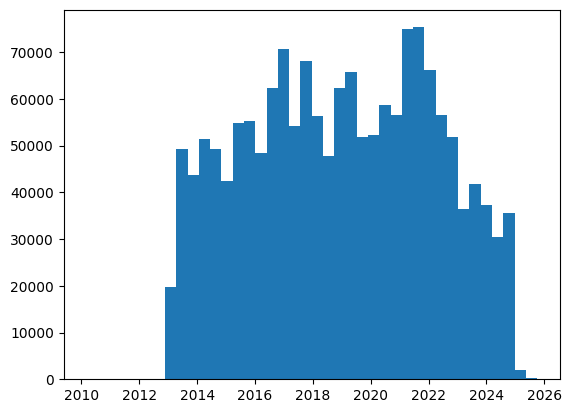

In [42]:
plt.hist(df["Date"], bins=40)    


### Question : In which departments did we build the most ? 

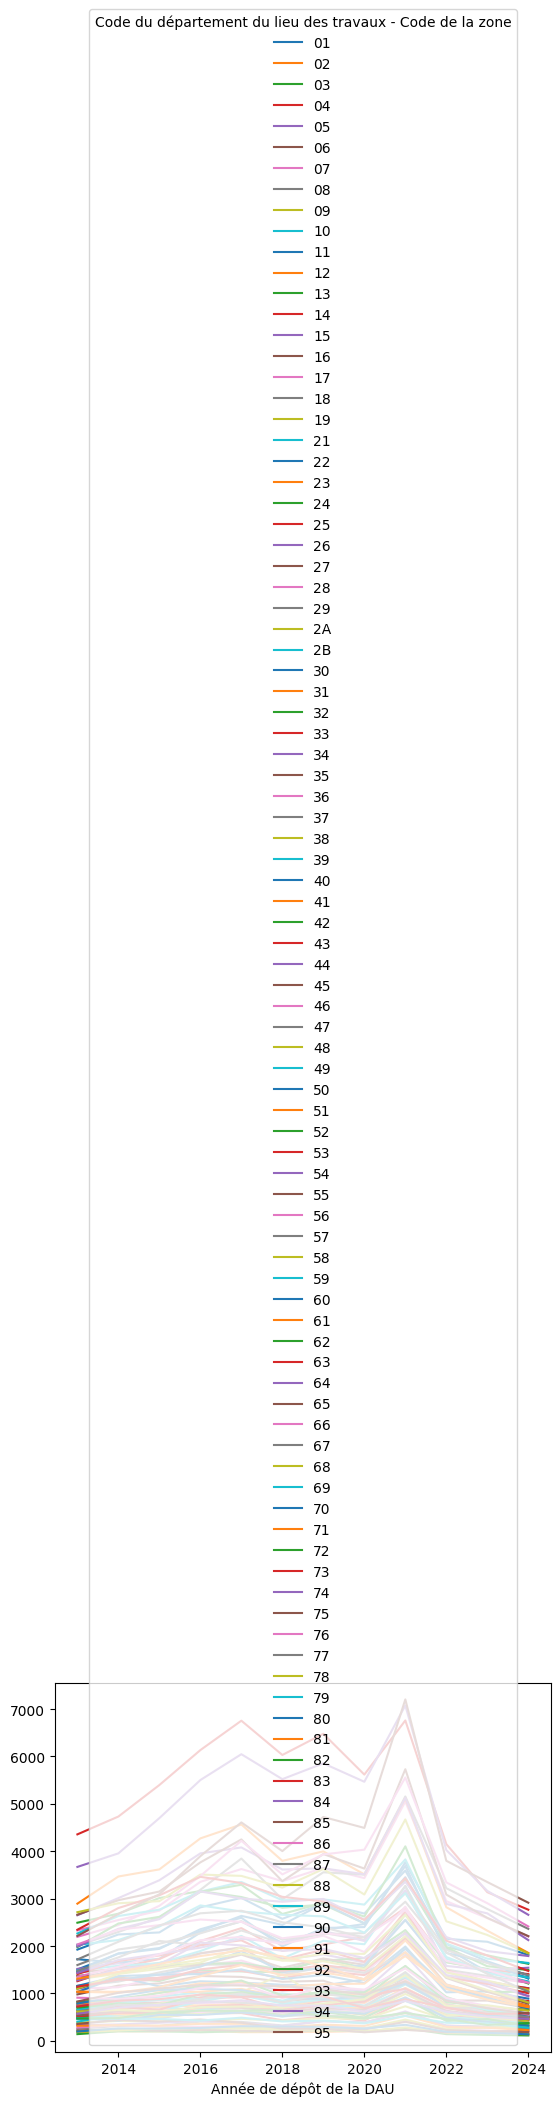

In [43]:
activity_per_department = df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot()


array([[<Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>],
       [<Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année d

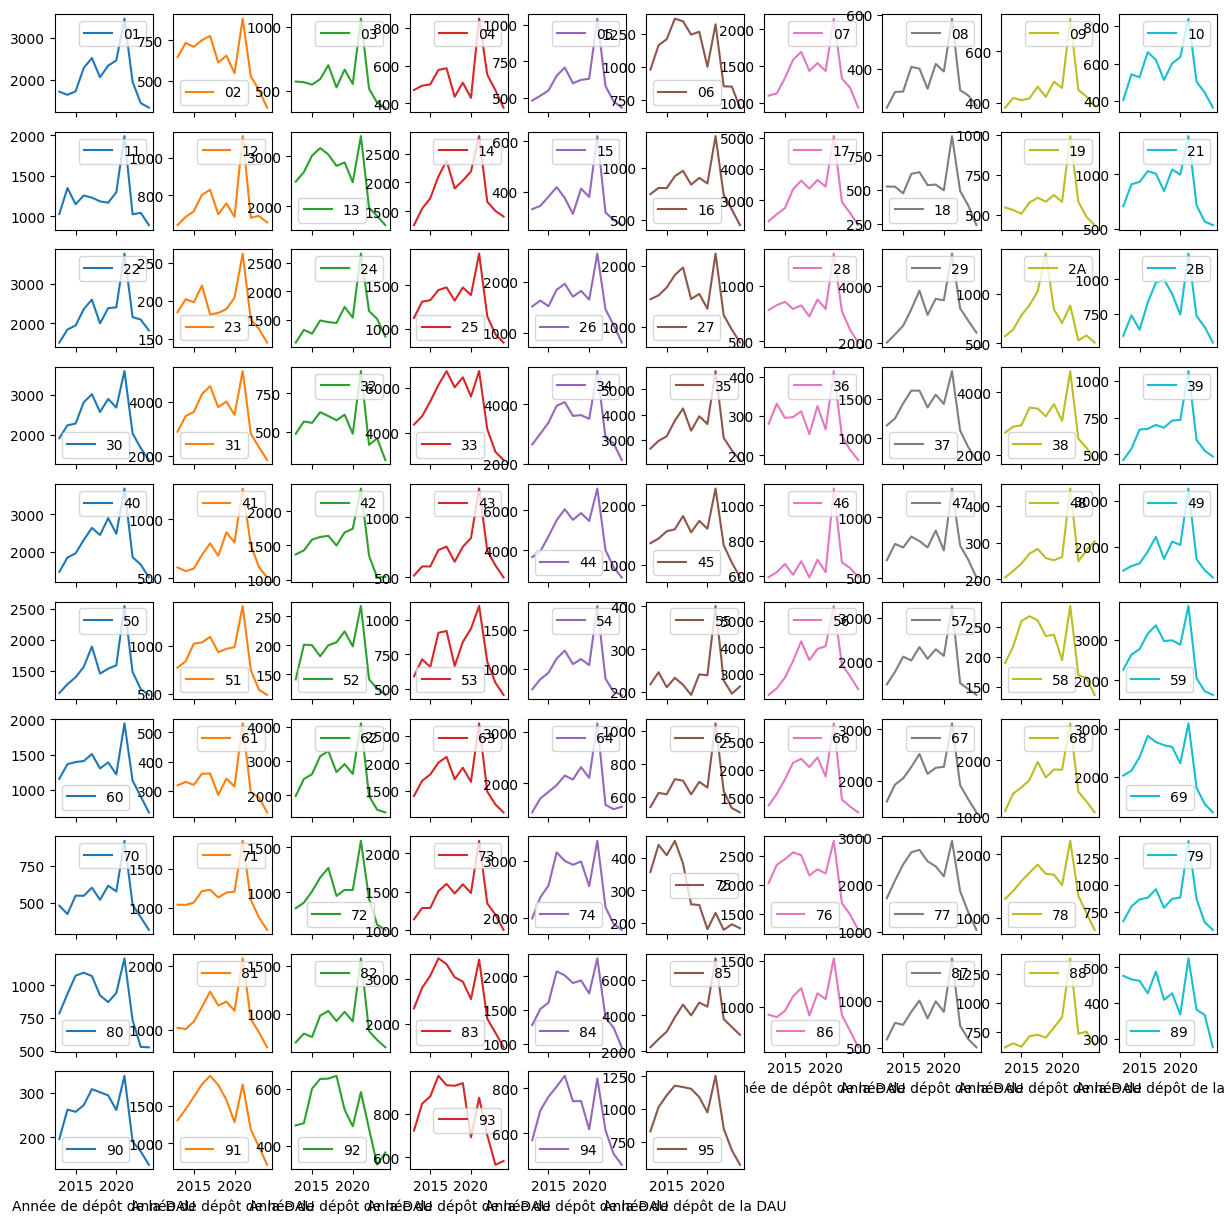

In [44]:
df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot(
    subplots=True,
    layout=(10,10),
    figsize=(15,15),
    legend=True 
)


In [45]:
activity_per_department = df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(1)
activity_per_department.sample(4)

Année de dépôt de la DAU                            2013  2014  2015  2016  \
Code du département du lieu des travaux - Code ...                           
04                                                   470   493   500   577   
65                                                   537   623   614   706   
37                                                  1159  1249  1443  1608   
83                                                  2344  2802  3071  3460   

Année de dépôt de la DAU                            2017  2018  2019  2020  \
Code du département du lieu des travaux - Code ...                           
04                                                   586   434   509   428   
65                                                   697   614   690   655   
37                                                  1608  1391  1556  1436   
83                                                  3329  3038  2939  2550   

Année de dépôt de la DAU                            2021  2022  2023  2024  
Code du département du lieu des travaux - Code ...                          
04                                                   850   552   469   376  
65                                                  1043   634   531   505  
37                                                  1861  1092   877   711  
83                                                  3430  2112  1800  1474

It's not very convenient to read and analyze, let's try making it clearer, however we will this time try to answer it in a more direct fashion i.e. clustering groups of datas

#### Clustering groups of departments

In [46]:
X = activity_per_department.fillna(0)
X = (X - X.mean(axis=1).values[:, None]) / X.std(axis=1).values[:, None]


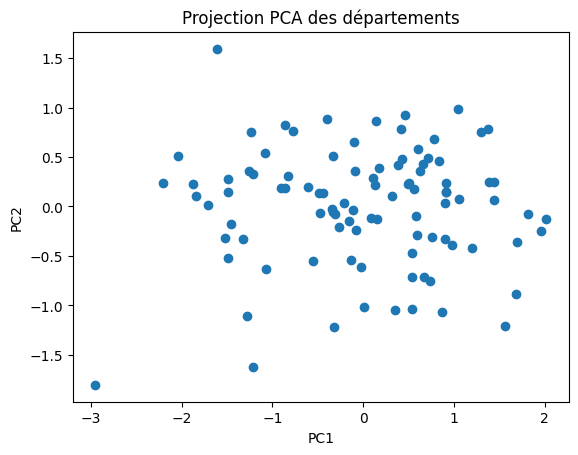

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.values)

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection PCA des départements")
plt.show()


In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X.values)

activity_per_department["cluster"] = labels


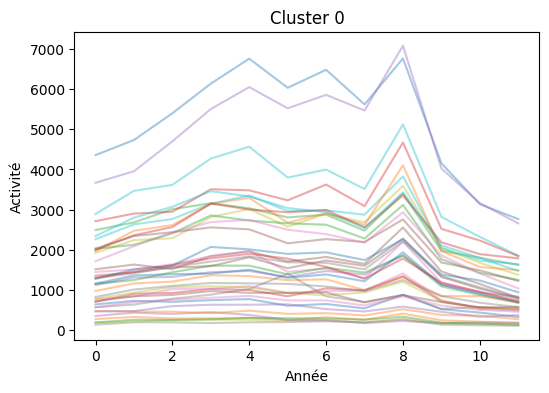

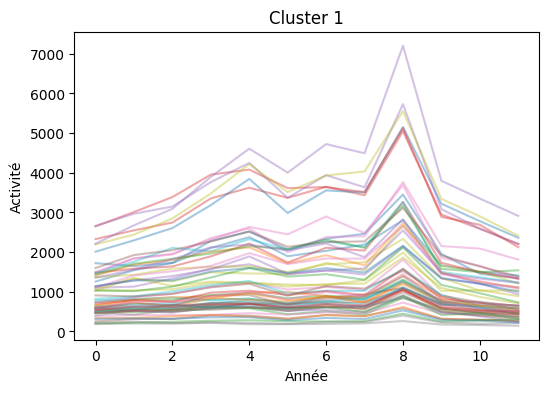

In [49]:
import matplotlib.pyplot as plt

for k in sorted(activity_per_department["cluster"].unique()):
    plt.figure(figsize=(6,4))
    for _, row in activity_per_department[
        activity_per_department["cluster"] == k
    ].drop(columns="cluster").iterrows():
        plt.plot(row.values, alpha=0.4)
    plt.title(f"Cluster {k}")
    plt.xlabel("Année")
    plt.ylabel("Activité")
    plt.show()


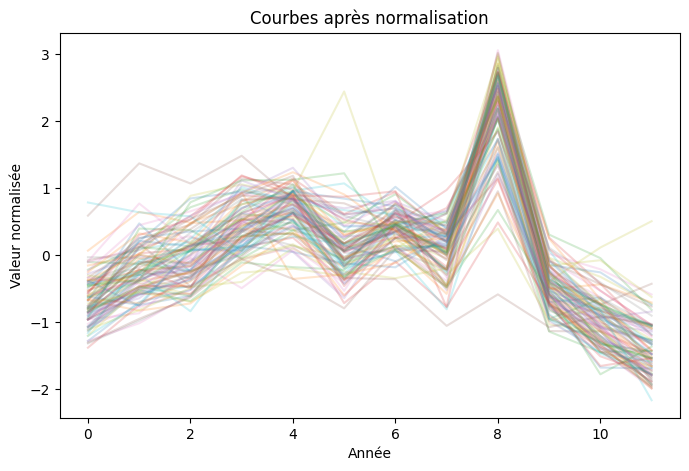

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for _, row in X.iterrows():
    plt.plot(row.values, alpha=0.2)
plt.title("Courbes après normalisation")
plt.xlabel("Année")
plt.ylabel("Valeur normalisée")
plt.show()


Let's first determine for a given year, in which departments did we build the most 
#### Q1 : For the year 2024, in which department did we build the most ? 

In [51]:
construction_activity2024 = activity_per_department[2024].sort_values().reset_index()

In [52]:
construction_activity2024.nunique()

Code du département du lieu des travaux - Code de la zone    96
2024                                                         93
dtype: int64

#### -> Q1 : Let's represent departments on a map 

In [53]:
deps = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson")

In [54]:
deps.index = deps.index.astype(str).str.zfill(2)
deps.head(50)


code                      nom  \
00   01                      Ain   
01   02                    Aisne   
02   03                   Allier   
03   04  Alpes-de-Haute-Provence   
04   05             Hautes-Alpes   
05   06          Alpes-Maritimes   
06   2A             Corse-du-Sud   
07   2B              Haute-Corse   
08   07                  Ardèche   
09   08                 Ardennes   
10   09                   Ariège   
11   10                     Aube   
12   11                     Aude   
13   12                  Aveyron   
14   13         Bouches-du-Rhône   
15   14                 Calvados   
16   15                   Cantal   
17   16                 Charente   
18   17        Charente-Maritime   
19   18                     Cher   
20   19                  Corrèze   
21   21                Côte-d'Or   
22   22            Côtes-d'Armor   
23   23                   Creuse   
24   24                 Dordogne   
25   25                    Doubs   
26   26                    Drôme   
27   27                     Eure   
28   28             Eure-et-Loir   
29   29                Finistère   
30   30                     Gard   
31   31            Haute-Garonne   
32   32                     Gers   
33   33                  Gironde   
34   34                  Hérault   
35   35          Ille-et-Vilaine   
36   36                    Indre   
37   37           Indre-et-Loire   
38   38                    Isère   
39   39                     Jura   
40   40                   Landes   
41   41             Loir-et-Cher   
42   42                    Loire   
43   43              Haute-Loire   
44   44         Loire-Atlantique   
45   45                   Loiret   
46   46                      Lot   
47   47           Lot-et-Garonne   
48   48                   Lozère   
49   49           Maine-et-Loire   

                                             geometry  
00  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
01  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
02  POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...  
03  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
04  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
05  MULTIPOLYGON (((7.06711 43.51365, 7.06665 43.5...  
06  MULTIPOLYGON (((8.5864 41.87389, 8.58667 41.87...  
07  MULTIPOLYGON (((9.40875 43.02232, 9.40662 43.0...  
08  POLYGON ((4.48313 45.23645, 4.4879 45.23218, 4...  
09  POLYGON ((4.23316 49.95775, 4.2369 49.95858, 4...  
10  POLYGON ((1.68842 43.27355, 1.69139 43.27173, ...  
11  POLYGON ((3.41479 48.39027, 3.41555 48.39373, ...  
12  POLYGON ((1.68842 43.27355, 1.69029 43.27437, ...  
13  POLYGON ((2.20748 44.61553, 2.20885 44.61631, ...  
14  MULTIPOLYGON (((5.3967 43.173, 5.39314 43.1730...  
15  MULTIPOLYGON (((-0.43055 48.86309, -0.43295 48...  
16  POLYGON ((2.50841 45.4785, 2.51056 45.47944, 2...  
17  POLYGON ((-0.10294 45.96966, -0.09758 45.97113...  
18  MULTIPOLYGON (((-1.11427 45.95173, -1.1163 45....  
19  POLYGON ((2.23921 47.62098, 2.24348 47.62084, ...  
20  POLYGON ((1.89873 45.69828, 1.89931 45.69828, ...  
21  MULTIPOLYGON (((4.11597 47.12334, 4.11 47.1261...  
22  MULTIPOLYGON (((-3.47716 48.88127, -3.47863 48...  
23  POLYGON ((2.16779 46.42407, 2.17254 46.42228, ...  
24  POLYGON ((0.62974 45.71457, 0.63094 45.71328, ...  
25  POLYGON ((6.80701 47.5628, 6.80981 47.55751, 6...  
26  POLYGON ((4.80049 45.29836, 4.80552 45.29935, ...  
27  POLYGON ((0.29722 49.42986, 0.3078 49.43063, 0...  
28  POLYGON ((0.81482 48.67017, 0.81727 48.67262, ...  
29  MULTIPOLYGON (((-4.0004 47.72283, -4.00391 47....  
30  POLYGON ((3.37365 44.17076, 3.38309 44.17041, ...  
31  POLYGON ((0.95398 43.78737, 0.956 43.78933, 0....  
32  POLYGON ((0.07605 43.98314, 0.07628 43.98202, ...  
33  MULTIPOLYGON (((-1.23902 44.59278, -1.23583 44...  
34  MULTIPOLYGON (((3.50066 43.2629, 3.50223 43.26...  
35  MULTIPOLYGON (((-2.15926 48.6372, -2.16138 48....  
36  POLYGON ((1.32667 47.18623, 1.33849 47.19554, ...  
37  POLYGON ((0.61443 47.69421, 0.6152

In [55]:
construction_activity2024 = construction_activity2024.merge(
    deps,
    left_on="Code du département du lieu des travaux - Code de la zone",
    right_on="code",
    how="left"
)

construction_activity2024.head(50)


Code du département du lieu des travaux - Code de la zone  2024 code  \
0                                                  52          114   52   
1                                                  58          137   58   
2                                                  90          138   90   
3                                                  23          145   23   
4                                                  75          184   75   
5                                                  36          188   36   
6                                                  55          213   55   
7                                                  61          225   61   
8                                                  18          242   18   
9                                                  08          263   08   
10                                                 15          269   15   
11                                                 89          276   89   
12                                                 48          304   48   
13                                                 70          316   70   
14                                                 32          319   32   
15                                                 02          332   02   
16                                                 10          364   10   
17                                                 03          367   03   
18                                                 04          376   04   
19                                                 92          377   92   
20                                                 09          387   09   
21                                                 05          431   05   
22                                                 19          435   19   
23                                                 16          446   16   
24                                                 53          456   53   
25                                                 94          461   94   
26                                                 39          486   39   
27                                                 28          489   28   
28                                                 51          490   51   
29                                                 43          499   43   
30                                                 47          501   47   
31                                                 87          503   87   
32                                                 41          504   41   
33                                                 65          505   65   
34                                                 2A          508   2A   
35                                                 80          527   80   
36                                                 21          536   21   
37                                                 2B          537   2B   
38                                                 86          552   86   
39                                                 95          575   95   
40                                                 72          578   72   
41                                                 79          583   79   
42                                                 93          583   93   
43                                                 46          592   46   
44                                                 88          635   88   
45                                                 82          647   82   
46                                                 12          654   12   
47                                                 54          657   54   
48                                                 60          683   60   
49                                                 06          688   06   

                        nom                                           geometry  
0               Haute-Marne  POLYGON ((4.67018 48.53189, 4.67374 48.53396, ...  
1              

In [56]:
construction_activity2024 = gpd.GeoDataFrame(
    construction_activity2024,
    geometry="geometry",
    crs=deps.crs
)

<Axes: >

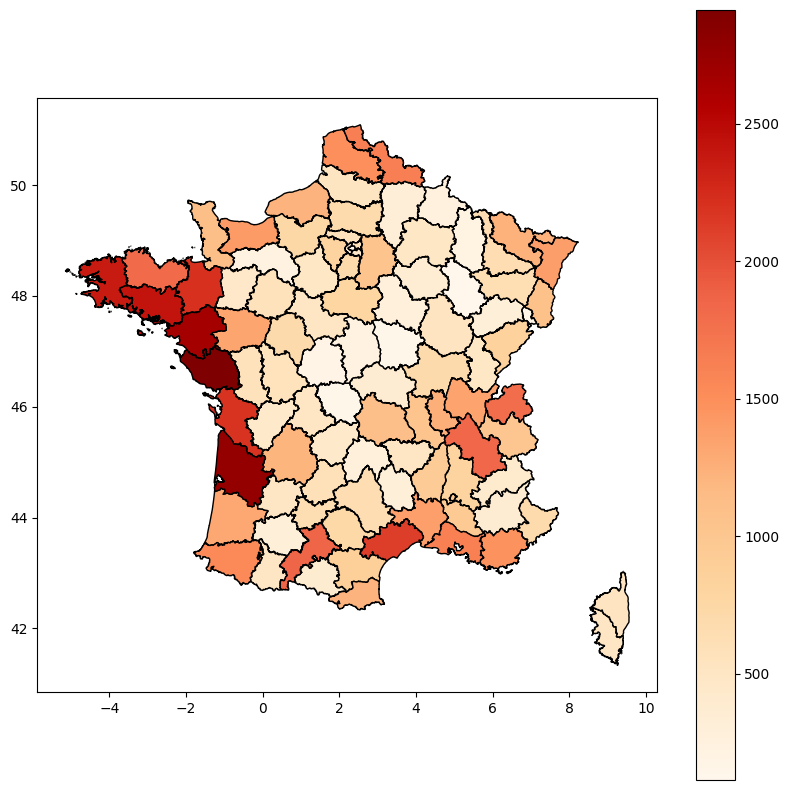

In [57]:
construction_activity2024.plot(
    column=2024,
    cmap="OrRd",
    legend=True,
    figsize=(10, 10),
    edgecolor="black"
) 

#### TODO -> Q1 What's happening in Bordeaux ? 

In [58]:
df.loc[
    df["Code du département du lieu des travaux - Code de la zone"] == "33",
    "Destination principale"
].value_counts()


Destination principale
habitation    62311
Name: count, dtype: int64

#### Q2 : In which department was growth the strongest ? 

In [59]:
growth_per_department = activity_per_department.pct_change(axis=1)



In [60]:
growth_per_department = growth_per_department.mean(axis=1).reset_index()


In [61]:
growth_per_department = growth_per_department.merge(
    deps,
    left_on="Code du département du lieu des travaux - Code de la zone",
    right_on="code",
    how="left"
)

In [62]:
growth_per_department = growth_per_department.rename(columns={0:"Avg_growth_rate"})

In [63]:
growth_per_department = gpd.GeoDataFrame(
    growth_per_department,
    geometry="geometry",
    crs=deps.crs
)

In [64]:
growth_per_department.columns

Index(['Code du département du lieu des travaux - Code de la zone',
       'Avg_growth_rate', 'code', 'nom', 'geometry'],
      dtype='object')

<Axes: >

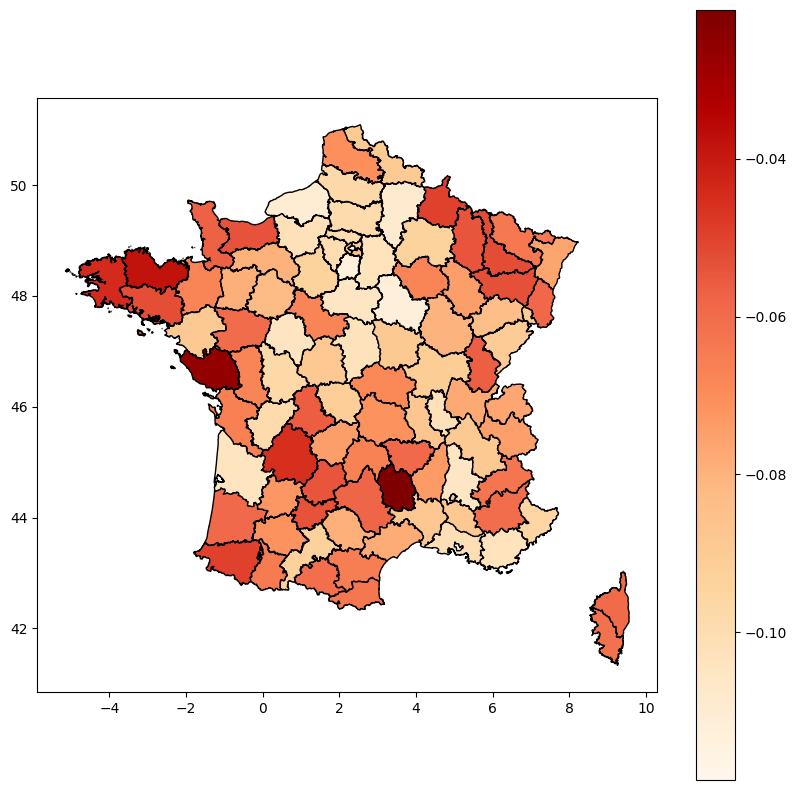

In [65]:
growth_per_department.plot(
    column="Avg_growth_rate",
    cmap="OrRd",
    legend=True,
    figsize=(10, 10),
    edgecolor="black"
) 

In [66]:
growth_per_department.sort_values(by="Avg_growth_rate", ascending=False).head(10)

Code du département du lieu des travaux - Code de la zone  Avg_growth_rate  \
48                                                 48               -0.021113   
85                                                 85               -0.025868   
20                                                 22               -0.038161   
27                                                 29               -0.044336   
22                                                 24               -0.045371   
64                                                 64               -0.049427   
7                                                  08               -0.049565   
54                                                 54               -0.052042   
56                                                 56               -0.052444   
88                                                 88               -0.053060   

   code                   nom  \
48   48                Lozère   
85   85                Vendée   
20   22         Côtes-d'Armor   
27   29             Finistère   
22   24              Dordogne   
64   64  Pyrénées-Atlantiques   
7    08              Ardennes   
54   54    Meurthe-et-Moselle   
56   56              Morbihan   
88   88                Vosges   

                                             geometry  
48  POLYGON ((3.36134 44.97141, 3.36229 44.97131, ...  
85  MULTIPOLYGON (((-2.30479 46.70942, -2.30209 46...  
20  MULTIPOLYGON (((-3.47716 48.88127, -3.47863 48...  
27  MULTIPOLYGON (((-4.0004 47.72283, -4.00391 47....  
22  POLYGON ((0.62974 45.71457, 0.63094 45.71328, ...  
64  POLYGON ((-0.24284 43.58498, -0.24233 43.58342...  
7   POLYGON ((4.23316 49.95775, 4.2369 49.95858, 4...  
54  MULTIPOLYGON (((5.45245 49.41235, 5.46144 49.4...  
56  MULTIPOLYGON (((-3.01322 47.41074, -3.01772 47...  
88  POLYGON ((5.47006 48.42093, 5.48238 48.41582, ...

In [67]:
activity_per_department.iloc[80:88]


Année de dépôt de la DAU                            2013  2014  2015  2016  \
Code du département du lieu des travaux - Code ...                           
80                                                   786   935  1074  1096   
81                                                  1035  1016  1131  1360   
82                                                   699   791   755   979   
83                                                  2344  2802  3071  3460   
84                                                  1277  1515  1610  2073   
85                                                  2214  2675  3092  3896   
86                                                   910   884   952  1112   
87                                                   587   763   743   881   

Année de dépôt de la DAU                            2017  2018  2019  2020  \
Code du département du lieu des travaux - Code ...                           
80                                                  1071   923   872   942   
81                                                  1600  1383  1444  1302   
82                                                  1028   922  1019   918   
83                                                  3329  3038  2939  2550   
84                                                  2013  1900  1938  1746   
85                                                  4608  4003  4723  4492   
86                                                  1201   901  1145  1081   
87                                                  1000   810   993   880   

Année de dépôt de la DAU                            2021  2022  2023  2024  \
Code du département du lieu des travaux - Code ...                           
80                                                  1206   734   530   527   
81                                                  2118  1173   965   732   
82                                                  1579   816   724   647   
83                                                  3430  2112  1800  1474   
84                                                  2266  1387  1238   947   
85                                                  7203  3798  3350  2914   
86                                                  1529   904   734   552   
87                                                  1450   732   590   503   

Année de dépôt de la DAU                            cluster  
Code du département du lieu des travaux - Code ...           
80                                                        0  
81                                                        1  
82                                                        1  
83                                                        0  
84                                                        0  
85                                                        1  
86                                                        1  
87                                                        1

### Interactive heatmap

In [68]:
df.loc[:,col_relevant].head()

Unnamed: 0.1 Code de la région du lieu des travaux - Code de la zone  \
1             1                                                 82        
2             2                                                 82        
3             3                                                 82        
4             4                                                 82        
5             5                                                 82        

  Code de la région du lieu des travaux - Libellé de la zone  \
1                                        Rhône-Alpes           
2                                        Rhône-Alpes           
3                                        Rhône-Alpes           
4                                        Rhône-Alpes           
5                                        Rhône-Alpes           

  Code du département du lieu des travaux - Code de la zone  \
1                                                 01          
2                                                 01          
3                                                 01          
4                                                 01          
5                                                 01          

  Code du département du lieu des travaux - Libellé de la zone  \
1                                                Ain             
2                                                Ain             
3                                                Ain             
4                                                Ain             
5                                                Ain             

  Code de la commune du lieu des travaux  Etat d’avancement du projet  \
1                                   1001                            6   
2                                   1001                            6   
3                                   1001                            6   
4                                   1001                            6   
5                                   1001                            5   

   Catégorie du demandeur (maître d’ouvrage) selon Sitadel  \
1                                                 10         
2                                                 10         
3                                                 10         
4                                                 10         
5                                                 10         

  Code d’activité principale de l’établissement d’un demandeur avéré en tant que personne morale  \
1                                                NaN                                               
2                                                NaN                                               
3                                                NaN                                               
4                                                NaN                                               
5                                                NaN                                               

   Catégorie juridique d’un demandeur avéré en tant que personne morale  ...  \
1                                                NaN                     ...   
2                                                NaN                     ...   
3                                                NaN                     ...   
4                                                NaN                     ...   
5                                                NaN                     ...   

  Type d’annexe  Type de résidence  Nombre total de logements créés  \
1             2                  9                              1.0   
2             2                  9                              1.0   
3             2                  9                              1.0   
4             2                  9                              1.0   
5             7                  9                              1.0   

  Nombre de logements démolis Nb de logements locatifs sociaux  \
1   

In [69]:
df['Geometry'] = df.apply(
    lambda x: Point(x["longitude"], x["latitude"]) 
    if x["longitude"] and x["latitude"] 
    else None,
    axis = 1
)

gdf = gpd.GeoDataFrame(
    df,              # les données
    geometry="Geometry",     # La colonne de géométrie
    crs='EPSG:4326'       # Système de coordonnées 
)

In [70]:
gdf = gdf.to_crs(epsg=2154)  # transformation du système de coordonnée pour plot hexbin


In [71]:
gdf_clean = gdf[
    (gdf.geometry.x.between(200_000, 1_200_000)) &
    (gdf.geometry.y.between(6_000_000, 7_200_000))
]


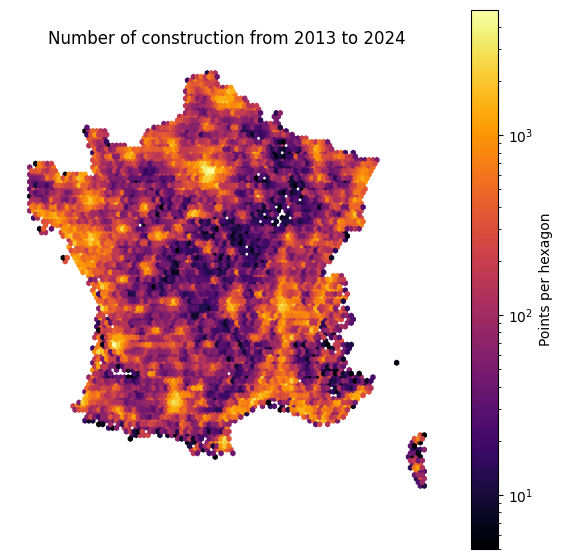

In [72]:
fig, ax = plt.subplots(figsize=(7, 7))

graph_heatmap_resid = ax.hexbin(
    gdf_clean.geometry.x,
    gdf_clean.geometry.y,
    gridsize=100,
    cmap="inferno",
    mincnt=5,
    bins="log" 
)

ax.set_aspect("equal")
ax.set_axis_off()

plt.colorbar(graph_heatmap_resid, label="Points per hexagon")
plt.title("Number of construction from 2013 to 2024")
plt.show()


We want to zoom on the Paris region

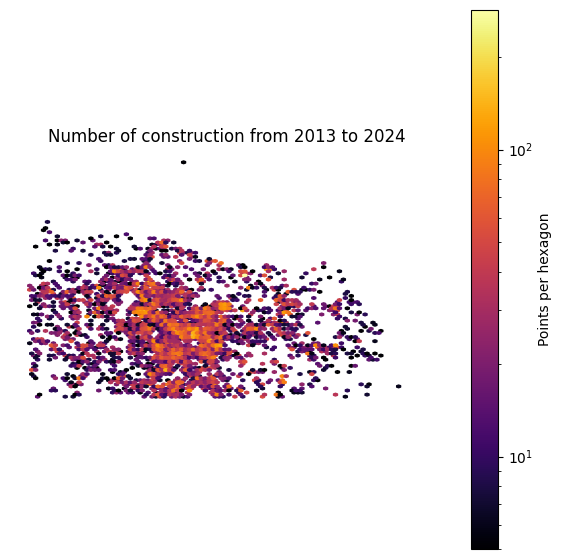

In [73]:
gdf_idf = gdf[gdf["Code de la région du lieu des travaux - Code de la zone"] == "11"]
gdf_idf = gdf_idf[
    gdf_idf.geometry.x.between(600_000, 750_000) &
    gdf_idf.geometry.y.between(6_840_000, 6_930_000)
]

fig, ax = plt.subplots(figsize=(7, 7))
graph_heatmap_resid_idf = ax.hexbin(
    gdf_idf.geometry.x,
    gdf_idf.geometry.y,
    gridsize=100,
    cmap="inferno",
    mincnt=5,
    bins="log" 
)

ax.set_aspect("equal")
ax.set_axis_off()


plt.colorbar(graph_heatmap_resid_idf, label="Points per hexagon")
plt.title("Number of construction from 2013 to 2024")
plt.show()

Pour mieux analyser la carte, on peut passer sur Folium pour avoir un fond de carte interactif

In [74]:
gdf_idf = gdf.loc[gdf["Code de la région du lieu des travaux - Code de la zone"] == "11"]


In [75]:
import folium
from folium.plugins import HeatMap

# passer en WGS84 (obligatoire pour folium)
gdf_wgs = gdf_idf.to_crs(epsg=4326)
gdf_wgs = gdf_wgs[
    gdf_wgs.geometry.notna() &
    ~gdf_wgs.geometry.is_empty &
    gdf_wgs.geometry.x.notna() &
    gdf_wgs.geometry.y.notna()
]

# centrer sur l'IDF
center = [
    gdf_wgs.geometry.y.mean(),
    gdf_wgs.geometry.x.mean()
]

m = folium.Map(
    location=center,
    zoom_start=9,
    tiles="CartoDB positron"
)

HeatMap(
    data=list(zip(
        gdf_wgs.geometry.y,
        gdf_wgs.geometry.x
    )),
    radius=10,
    blur=15
).add_to(m)

m


### Question : Are where real estate prices high where people create the most housings, an analysis on a more granular level 

We hereby assume that supply costs are more or less the same on the whole territory, which is far from being an absurd hypothesis. 
Accordingly, the only reason why prices are different from one place to another is the difference in demand. 
We hereby take prices as an indicator of positive aggregate demand

In [76]:
col_relevant =  [c for c in df.columns if c not in col_irrelevant] #on actualise pour ajouter la colonne géométrie nouvellement créée 
df.loc[:,col_relevant].sample()

Unnamed: 0.1 Code de la région du lieu des travaux - Code de la zone  \
689511        689511                                                 24        

       Code de la région du lieu des travaux - Libellé de la zone  \
689511                                             Centre           

       Code du département du lieu des travaux - Code de la zone  \
689511                                                 37          

       Code du département du lieu des travaux - Libellé de la zone  \
689511                                     Indre-et-Loire             

       Code de la commune du lieu des travaux  Etat d’avancement du projet  \
689511                                  37266                            6   

        Catégorie du demandeur (maître d’ouvrage) selon Sitadel  \
689511                                                 10         

       Code d’activité principale de l’établissement d’un demandeur avéré en tant que personne morale  \
689511                                                NaN                                               

        Catégorie juridique d’un demandeur avéré en tant que personne morale  \
689511                                                NaN                      

        ... Nombre total de logements créés  Nombre de logements démolis  \
689511  ...                             1.0                          0.0   

        Nb de logements locatifs sociaux Nb de logements aidé (hors ptz)  \
689511                               0.0                             0.0   

       Nb de logements ptz                          Adresse_complete  \
689511                 0.0  12 RUE FLORENCE ARTHAUD LE PARADI VEIGNE   

       longitude  latitude       Date                   Geometry  
689511  0.742037  47.28364 2020-11-01  POINT (0.742037 47.28364)  

[1 rows x 37 columns]

We then select a resolution for the hexagon, resolution 7 seem to be the optimal one as each hexagon will cover a surface of approximately 15m². Knowing there are approximately 1 million points in the database, each hexagon will have 

In [77]:
import h3


In [78]:
gdf = gpd.GeoDataFrame(
    df,              # les données
    geometry="Geometry",     # La colonne de géométrie
    crs='EPSG:4326'       # Système de coordonnées 
)

In [79]:
print(gdf.crs)
print(gdf.geometry.y.min(), gdf.geometry.y.max())
print(gdf.geometry.x.min(), gdf.geometry.x.max())
verif_gdf = gdf.geometry.isna().to_frame()

bad = gdf[
    (~gdf.geometry.y.between(-90, 90)) |
    (~gdf.geometry.x.between(-180, 180)) |
    gdf.geometry.isna() |
    gdf.geometry.is_empty |
    (gdf.geometry.geom_type != "Point")
]

len(bad)


EPSG:4326
-22.289073 51.081244
-149.561753 166.614127


0

In [83]:
gdf["hexagon"] = gdf.geometry.apply(lambda coord : h3.latlng_to_cell(coord.x,coord.y, 6))

In [81]:
hex_counts = (
    gdf
    .groupby("hexagon")
    .size()
    .reset_index(name="n_points")
)


In [82]:
hex_counts

hexagon  n_points
0      8718c1922ffffff        59
1      8718c5294ffffff         1
2      8718c529effffff         1
3      8718c5645ffffff         8
4      8718c564effffff         9
...                ...       ...
96623  87e6e6d05ffffff         1
96624  87e6e6d0cffffff         2
96625  87e6e6d1bffffff         2
96626  87e6e6d1dffffff         9
96627  87e6e6d23ffffff         2

[96628 rows x 2 columns]